## Plot results

The purpose of this notebook is to visualize models' performances singlehandedly and/or with respect to each other's. It expects the selected models to have already gone through training using the `run_exp_script.py` script.

## Imports

In [79]:
%load_ext autoreload
%autoreload 2
import pickle
import glob
import pandas as pd
import seaborn as sns
import geopandas as gpd
from matplotlib import pyplot as plt
from utils import plot_utils as plot
from models.build_models import build_model
from data_handlers.dataset_classes import MSDataset, NLDataset, MSNLDataset
from testing import test
import torch
from sklearn.metrics import r2_score

CKPT_PATH = 'models/checkpoints/'
DATASET   = 'data/dataset_viirs_only.csv'
# DATASET   = 'data/dataset.csv'
DATA_DIR  = 'data/landsat_7_less/'
# DATA_DIR  = 'data/landsat_7/'
FOLDS     = 'data/dhs_incountry_folds_viirs_only.pkl'
# FOLDS     = 'data/dhs_incountry_folds_all.pkl'
bg_map = gpd.read_file('data/africa.json')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
df = pd.read_csv(DATASET)
df = df[df['urban_rural']!=-1]
print('sample size:', len(df))
# df = df.rename(columns={'wealthpooled':'Asset Wealth','urban_rural':'Urban vs Rural'})
# df['Urban vs Rural'] = df['Urban vs Rural'].replace(1.0,'Urban')
# df['Urban vs Rural'] = df['Urban vs Rural'].replace(0.,'Rural')
sns.set_theme()
sns.set_context('paper')
sns.catplot(df, y='year', orient='h',kind='count',palette='bone_r')

32468


## MS

In [3]:
RESULT_PATH = 'models/results/ms_2_*'
result_list = glob.glob(RESULT_PATH)
# Load Results
results = dict()
for i in range(len(result_list)):
    with open(result_list[i], 'rb') as f:
        results[i] = pickle.load(f)
# Load Config
with open( 'configs/default_config.pkl','rb') as f:
    data_config = pickle.load(f)

In [4]:
print(result_list)

['models/results/ms__2__0.pkl']


[]

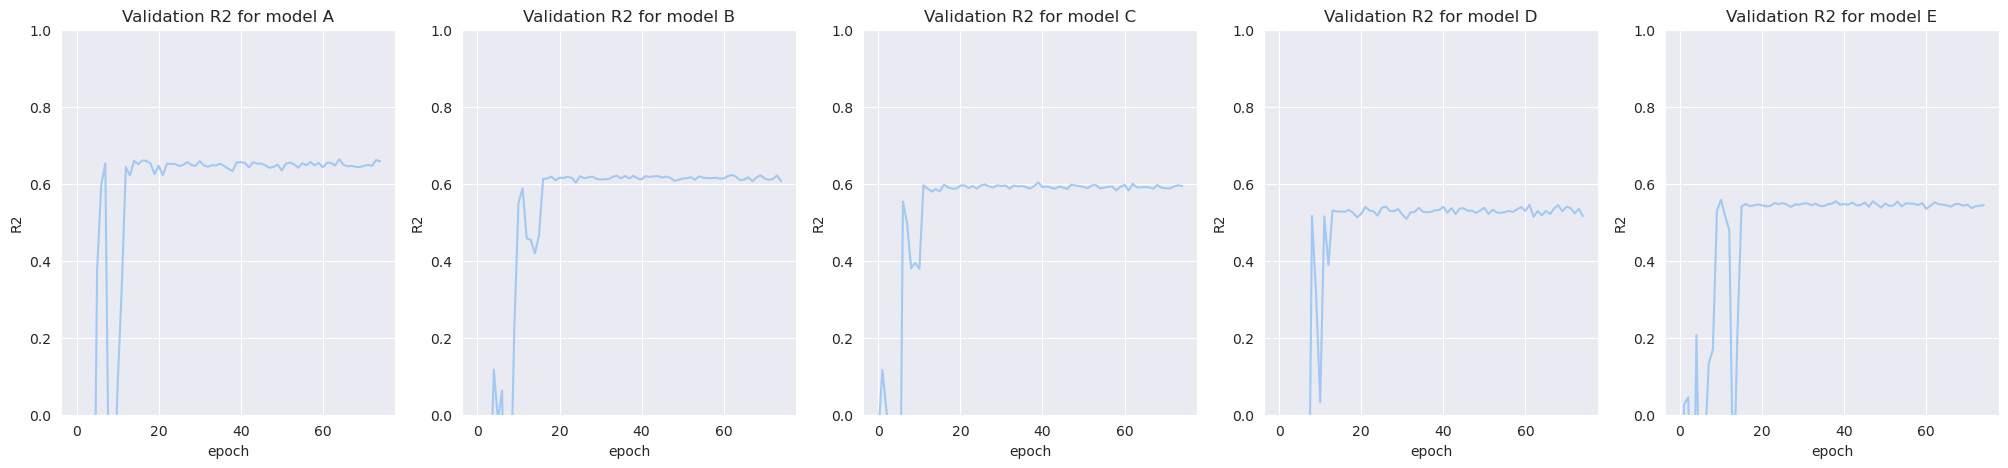

In [5]:
multi_val_dict, val_dataframes = dict(), dict()
for i in results:
    multi_val_dict[i] = plot.extract_crossval_results(results=results[i], var='test_r2', new_var="R2", to_cpu=False)
    val_dataframes[i] = pd.DataFrame.from_dict(multi_val_dict[i])

# Plot preparation
sns.set_palette('pastel')
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,5,figsize=(25, 5))

for fold in ['A','B','C','D','E']:
    x = ord(fold)-ord('A')
    ax[x].set_title(f'Validation R2 for model {fold}')
    for i in results:
        sns.lineplot(ax=ax[x], data=val_dataframes[i][val_dataframes[i].fold==fold], x="epoch", y="R2",legend=True).set(ylim=(0, 1))
plt.plot()

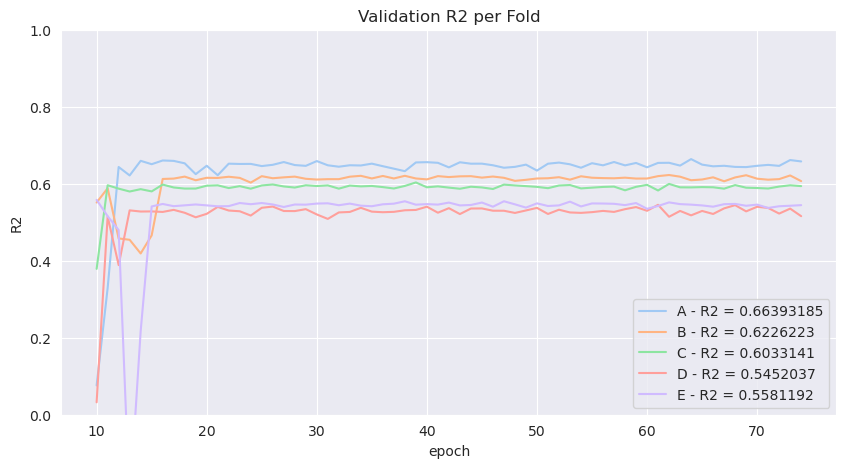

In [8]:
# VAL PERFORMANCES
multi_val_dict = plot.extract_crossval_results(results=results[0], var='test_r2', new_var="R2", to_cpu=False)
df = pd.DataFrame.from_dict(multi_val_dict)
df = df[df.epoch >= 10] # skip unstable first epochs
# Figures
sns.set_palette('pastel')
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.set_title('Validation R2 per Fold')
sns.lineplot(ax=ax, data=df, x="epoch", y="R2", hue="fold",legend=True, palette="pastel",errorbar=None).set(ylim=(0, 1))
ax.legend(title='', loc='lower right', labels=['A - R2 = '+str(df[df.fold=='A'].R2.max()), 'B - R2 = '+str(df[df.fold=='B'].R2.max()), 'C - R2 = '+str(df[df.fold=='C'].R2.max()), 'D - R2 = '+str(df[df.fold=='D'].R2.max()), 'E - R2 = '+str(df[df.fold=='E'].R2.max())])

In [26]:
save_path='results/yeh_ms.csv'
model_config_filename = 'configs/resnet18_ms_gs.json'
df_test = test.main(
    write_path=save_path,
    data_config_filename='configs/default_config.pkl',
    fold_path=FOLDS,
    network_config_filename=model_config_filename,
    dataset=pd.read_csv(DATASET),
    model_type="ms"
)

In [57]:
save_path='results/yeh_ms.csv'
df_test = pd.read_csv(save_path)
df_test = df_test.rename(columns={"wealthpooled": "True Wealth", "predicted_wealth": "Predicted Wealth"})

In [58]:
r2_all = r2_score(df_test['True Wealth'], df_test['Predicted Wealth'])
r2_all

0.6083494008598578

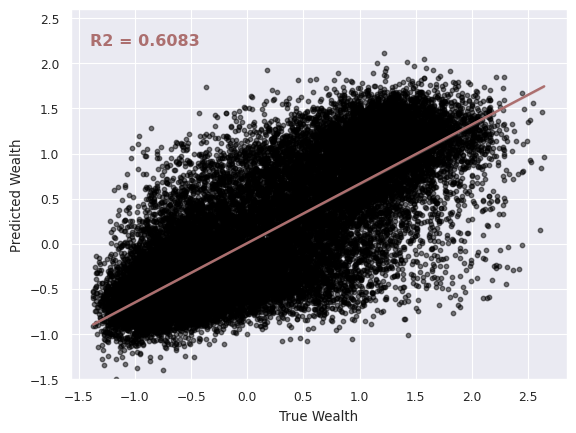

In [59]:
pal = sns.color_palette("pink")
sns.set_style("darkgrid", {'axes.grid' : True})
ax = sns.regplot(x="True Wealth", y="Predicted Wealth", data=df_test,x_ci='sd', marker='o', scatter_kws={'alpha':0.5,'color':'black', 's':10}, line_kws={'color':pal.as_hex()[1]}).set_ylim(-1.5, 2.6)
plt.text(-1.4,2.2, 'R2 = ' + str(round(r2_all,4)), fontsize='large', weight='bold', color=pal.as_hex()[1])
plt.show()

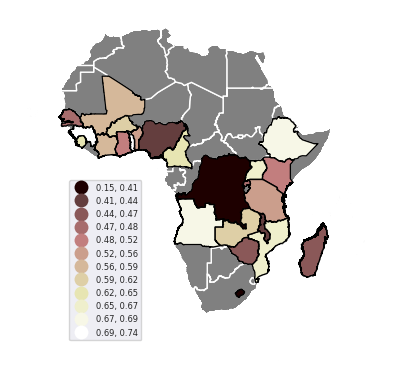

In [30]:
plot.country_plot(
    bg_map=bg_map,
    data=df_test,
    cmap='pink',
    bg_color='gray',
    edgecolor='white'
)

sample size: 11874
4426 7448


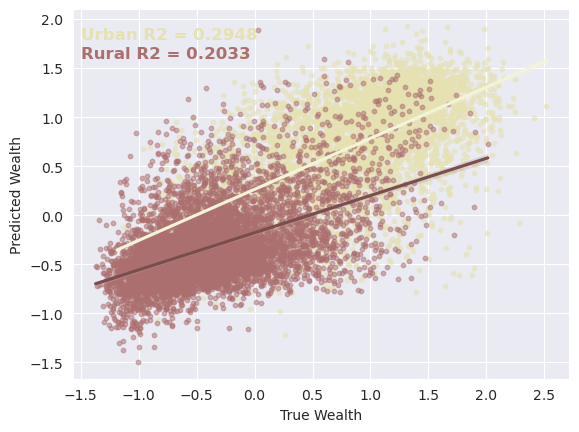

In [31]:
df_test_ur = df_test[df_test['urban_rural']!=-1]
print('sample size:', len(df_test_ur))
df_test_ur = df_test_ur.rename({'urban_rural':'Urban vs Rural'},axis=1)
plot.split_regplot(
    data=df_test_ur,
    col_to_split='Urban vs Rural',
    newcol_name='Urban vs Rural',
    split_val=1.,
    labelinf='Rural',
    labelsup='Urban',
    pal=sns.color_palette("pink"),
    scatter_kws={'alpha':0.2, 's':10},
    line_kws= {'alpha':1., 'linewidth':3}
    )

## NL

In [4]:
RESULT_PATH = 'models/results/nl_'
result_list = glob.glob(RESULT_PATH)
# Load Results
results = dict()
for i in range(len(result_list)):
    with open(result_list[i], 'rb') as f:
        results[i] = pickle.load(f)
# Load Config
with open( 'configs/default_config.pkl','rb') as f:
    data_config = pickle.load(f)

First, we compare the performances of each model - *i.e.* A, B, C, D, E - for different hyperparameters settings. Henceforth we select the best ones to produce the test end-results.

In [ ]:
multi_val_dict, val_dataframes = dict(), dict()
for i in results:
    multi_val_dict[i] = plot.extract_crossval_results(results=results[i], var='test_r2', new_var="R2", to_cpu=False)
    val_dataframes[i] = pd.DataFrame.from_dict(multi_val_dict[i])

# Plot preparation
sns.set_palette('pastel')
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,5,figsize=(25, 5))

for fold in ['A','B','C','D','E']:
    x = ord(fold)-ord('A')
    ax[x].set_title(f'Validation R2 for model {fold}')
    for i in results:
        sns.lineplot(ax=ax[x], data=val_dataframes[i][val_dataframes[i].fold==fold], x="epoch", y="R2",legend=True)#.set(ylim=(0, 1))
plt.plot()

Validation Results

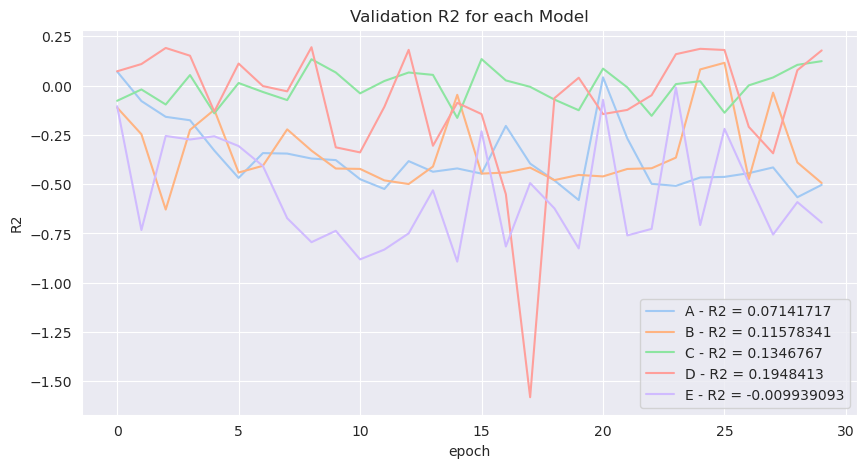

In [5]:
# VAL PERFORMANCES
multi_val_dict = plot.extract_crossval_results(results=results[0], var='test_r2', new_var="R2", to_cpu=False)
df = pd.DataFrame.from_dict(multi_val_dict)
# df = df[df.epoch >= 10] # skip unstable first epochs
# Figures
sns.set_palette('pastel')
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.set_title('Validation R2 for each Model')
sns.lineplot(ax=ax, data=df, x="epoch", y="R2", hue="fold",legend=True, palette="pastel",errorbar=None)#.set(ylim=(0, 1))
ax.legend(title='', loc='lower right', labels=['A - R2 = '+str(df[df.fold=='A'].R2.max()), 'B - R2 = '+str(df[df.fold=='B'].R2.max()), 'C - R2 = '+str(df[df.fold=='C'].R2.max()), 'D - R2 = '+str(df[df.fold=='D'].R2.max()), 'E - R2 = '+str(df[df.fold=='E'].R2.max())])

In [20]:
save_path='results/nl.csv'
model_config_filename = 'configs/resnet18_nl_gs.json'
df_test = test.main(
    write_path=save_path,
    data_config_filename='configs/default_config.pkl',
    fold_path=FOLDS,
    network_config_filename=model_config_filename,
    dataset=pd.read_csv(DATASET),
    model_type="nl"
)

models/checkpoints/enhanced/nl_A.pth
models/checkpoints/enhanced/nl_B.pth
models/checkpoints/enhanced/nl_C.pth
models/checkpoints/enhanced/nl_D.pth
models/checkpoints/enhanced/nl_E.pth


In [21]:
save_path='results/nl.csv'
df_test = pd.read_csv(save_path)
df_test = df_test.rename(columns={"wealthpooled": "True Wealth", "predicted_wealth": "Predicted Wealth"})

In [22]:
r2_all = r2_score(df_test['True Wealth'], df_test['Predicted Wealth'])
r2_all

0.6796921827270873

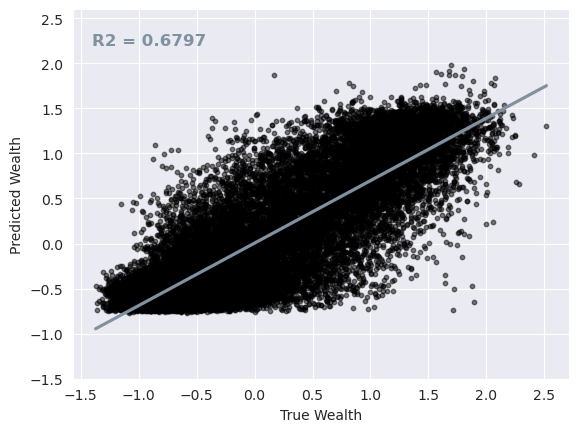

In [23]:
pal = sns.color_palette("bone")
ax = sns.regplot(x="True Wealth", y="Predicted Wealth", data=df_test,x_ci='sd', marker='o', scatter_kws={'alpha':0.5,'color':'black', 's':10}, line_kws={'color':pal.as_hex()[3]}).set_ylim(-1.5, 2.6)
plt.text(-1.4,2.2, 'R2 = ' + str(round(r2_all,4)), fontsize='large', weight='bold', color=pal.as_hex()[3])
plt.show()


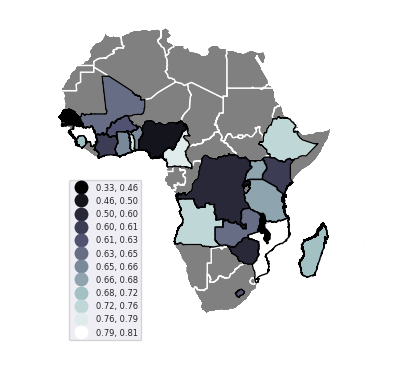

In [24]:
plot.country_plot(
    bg_map=bg_map,
    data=df_test,
    cmap='bone',
    bg_color='gray',
    edgecolor='white'
)

sample size: 11874
4426 7448


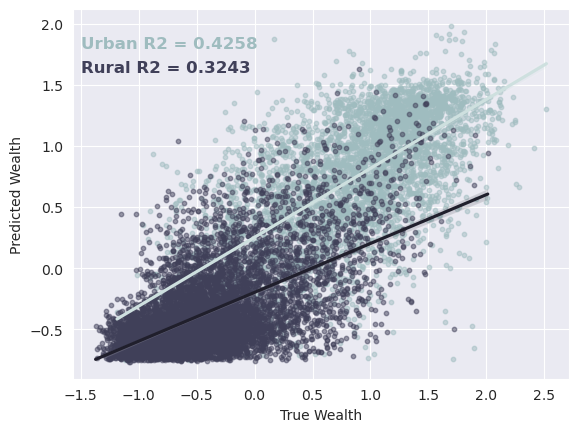

In [25]:
df_test_ur = df_test[df_test['urban_rural']!=-1]
print('sample size:', len(df_test_ur))
df_test_ur = df_test_ur.rename({'urban_rural':'Urban vs Rural'},axis=1)
plot.split_regplot(
    data=df_test_ur,
    col_to_split='Urban vs Rural',
    newcol_name='Urban vs Rural',
    split_val=1.,
    labelinf='Rural',
    labelsup='Urban',
    pal=sns.color_palette("bone"),
    scatter_kws={'alpha':0.2, 's':10},
    line_kws= {'alpha':1., 'linewidth':3}
    )

## MSNL

In [61]:
RESULT_PATH = 'models/results/msnl_best_*'
result_list = glob.glob(RESULT_PATH)
# Load Results
results = dict()
for i in range(len(result_list)):
    with open(result_list[i], 'rb') as f:
        results[i] = pickle.load(f)
# Load Config
with open( 'configs/default_config.pkl','rb') as f:
    data_config = pickle.load(f)
result_list

['models/results/msnl_best_0.pkl', 'models/results/msnl_best__0.pkl']

[]

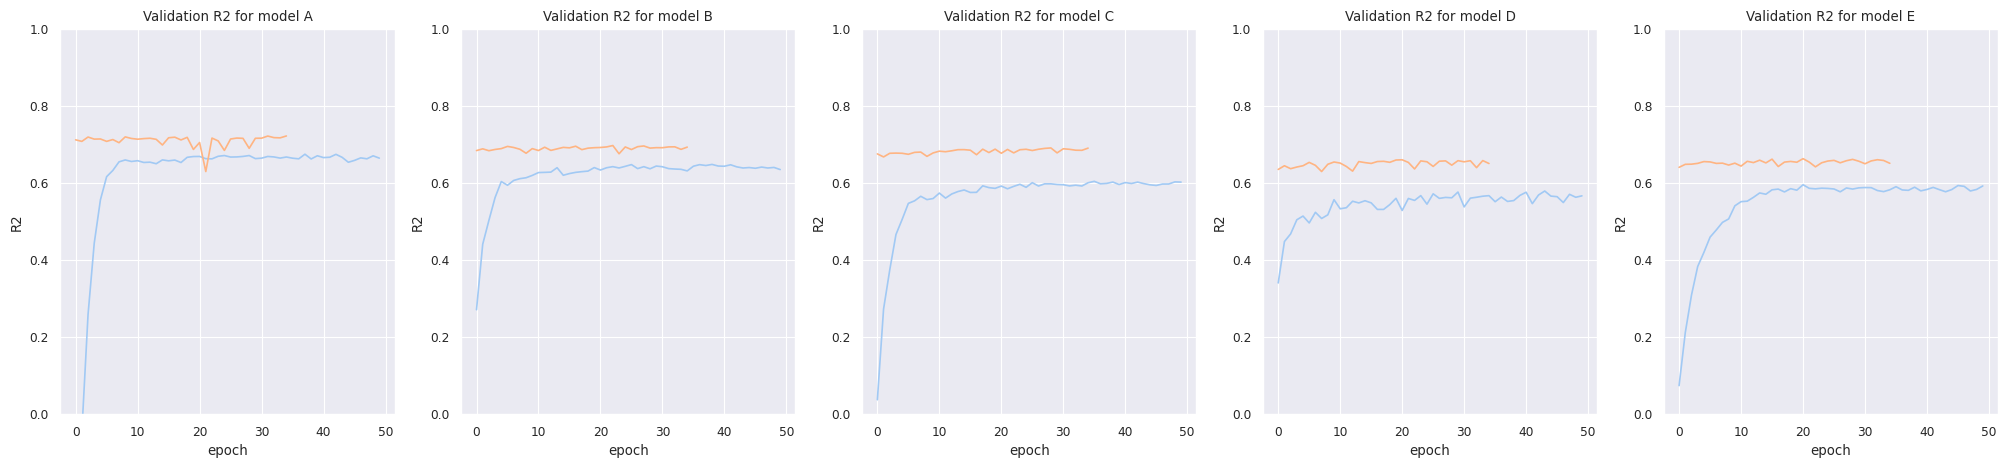

In [62]:
multi_val_dict, val_dataframes = dict(), dict()
for i in results:
    multi_val_dict[i] = plot.extract_crossval_results(results=results[i], var='test_r2', new_var="R2", to_cpu=False)
    val_dataframes[i] = pd.DataFrame.from_dict(multi_val_dict[i])

# Plot preparation
sns.set_palette('pastel')
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,5,figsize=(25, 5))

for fold in ['A','B','C','D','E']:
    x = ord(fold)-ord('A')
    ax[x].set_title(f'Validation R2 for model {fold}')
    for i in results:
        sns.lineplot(ax=ax[x], data=val_dataframes[i][val_dataframes[i].fold==fold], x="epoch", y="R2",legend=True).set(ylim=(0, 1))
plt.plot()

{'R2': [-0.49219623, -0.046812702, 0.25797957, 0.44338942, 0.5561393, 0.616234, 0.6323793, 0.6547386, 0.65965414, 0.65569466, 0.6576863, 0.65312445, 0.6538667, 0.6498435, 0.6598051, 0.6573765, 0.6593794, 0.65299386, 0.6665244, 0.6685165, 0.6687809, 0.66295344, 0.66250676, 0.6691864, 0.67110133, 0.6671617, 0.66750556, 0.66878146, 0.67111963, 0.6631243, 0.6642956, 0.6687144, 0.6674871, 0.6644311, 0.66729385, 0.664221, 0.6625829, 0.6745509, 0.66223985, 0.67054456, 0.66576153, 0.6666943, 0.6742527, 0.6664515, 0.6536632, 0.6585234, 0.6650233, 0.6626314, 0.67039555, 0.6643751, 0.27065998, 0.44061437, 0.5026562, 0.56216335, 0.6035638, 0.59392625, 0.6063814, 0.61105293, 0.6134272, 0.61950755, 0.6268902, 0.6274135, 0.62803024, 0.6395357, 0.61988705, 0.6242967, 0.6274223, 0.6292362, 0.63073397, 0.639815, 0.6334599, 0.639441, 0.642243, 0.638826, 0.6430631, 0.6475881, 0.6371713, 0.64220953, 0.63670284, 0.64377815, 0.6420114, 0.6371774, 0.6360678, 0.63533145, 0.6312135, 0.6433879, 0.6474446, 0.6451

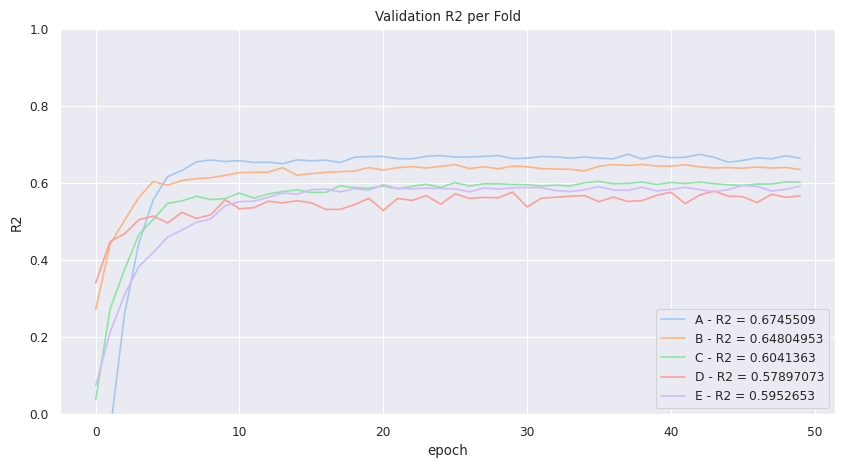

In [65]:
# VAL PERFORMANCES
multi_val_dict = plot.extract_crossval_results(results=results[0], var='test_r2', new_var="R2", to_cpu=False)
print(multi_val_dict)
df = pd.DataFrame.from_dict(multi_val_dict)
# Figures
sns.set_palette('pastel')
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.set_title('Validation R2 per Fold')
sns.lineplot(ax=ax, data=df, x="epoch", y="R2", hue="fold",legend=True, palette="pastel",errorbar=None).set(ylim=(0, 1))
ax.legend(title='', loc='lower right', labels=['A - R2 = '+str(df[df.fold=='A'].R2.max()), 'B - R2 = '+str(df[df.fold=='B'].R2.max()), 'C - R2 = '+str(df[df.fold=='C'].R2.max()), 'D - R2 = '+str(df[df.fold=='D'].R2.max()), 'E - R2 = '+str(df[df.fold=='E'].R2.max())])

In [66]:
save_path='results/msnl_best.csv'
model_config_filename = 'configs/resnet18_msnl_gs.json'
df_test = test.main(
    write_path=save_path,
    data_config_filename='configs/default_config.pkl',
    fold_path=FOLDS,
    network_config_filename=model_config_filename,
    dataset=pd.read_csv(DATASET),
    model_type="msnl"
)

In [67]:
save_path='results/msnl_best.csv'
df_test = pd.read_csv(save_path)
df_test = df_test.rename(columns={"wealthpooled": "True Wealth", "predicted_wealth": "Predicted Wealth"})

In [68]:
df_test= df_test[~df_test['Predicted Wealth'].isna()]
r2_all = r2_score(df_test['True Wealth'], df_test['Predicted Wealth'])
r2_all

0.6937957650077891

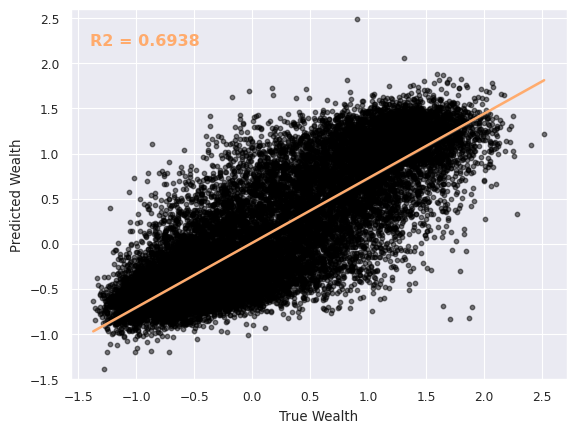

In [74]:
pal = sns.color_palette("copper")
sns.regplot(x="True Wealth", y="Predicted Wealth", data=df_test,x_ci='sd', marker='o', scatter_kws={'alpha':0.5,'color':'black', 's':10}, line_kws={'color':pal.as_hex()[5]}).set_ylim(-1.5, 2.6)
plt.text(-1.4,2.2, 'R2 = ' + str(round(r2_all,4)), fontsize='large', weight='bold', color=pal.as_hex()[5])
plt.show()

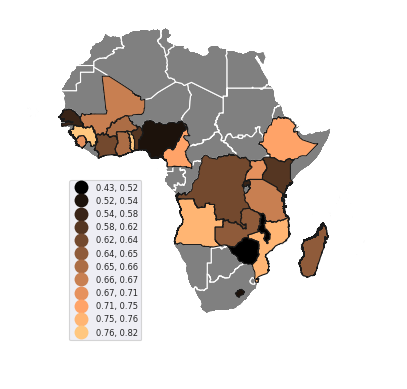

In [75]:
plot.country_plot(
    bg_map=bg_map,
    data=df_test,
    cmap='copper',
    bg_color='gray',
    edgecolor='white'
)

sample size: 11874
4426 7448


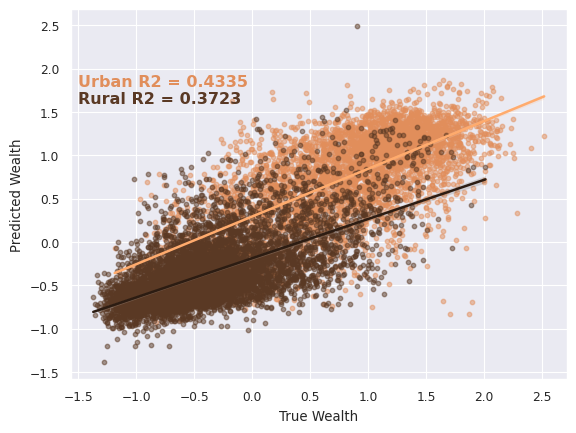

In [76]:
df_test_ur = df_test[df_test['urban_rural']!=-1]
print('sample size:', len(df_test_ur))
df_test_ur = df_test_ur.rename({'urban_rural':'Urban vs Rural'},axis=1)
plot.split_regplot(
    data=df_test_ur,
    col_to_split='Urban vs Rural',
    newcol_name='Urban vs Rural',
    split_val=1.,
    labelinf='Rural',
    labelsup='Urban',
    pal=sns.color_palette("copper"),
    scatter_kws={'alpha':0.2, 's':10},
    line_kws= {'alpha':1., 'linewidth':3}
    )